In [1]:
import datetime

import numpy             as np
import matplotlib.pyplot as plt

from CCfun  import in_range
from CCfun  import filter_df
from CCfun  import longer_than_exwl
from CCfun  import find_crystal_position
from CCfun  import compute_baseline_between

from CCfit  import fit
from CCfit  import polynom
from CCfit  import gauss
from CCfit  import double_gauss

from CCplot import auto_plot_style
from CCplot import plot1d
from CCplot import plot2d

from CCio import load_and_process

In [2]:
%matplotlib inline

auto_plot_style({"lines.linewidth": 2, "font.size":20})

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
SPIKES_THRESHOLD = 150

def remove_spikes(data):
    diff    = np.append([0], np.diff(data.counts))
    ok      = diff < SPIKES_THRESHOLD
    counts  = data.counts .where(ok, np.nan)
    bkgsub  = data.bkgsub .where(ok, np.nan)
    rate    = data.rate   .where(ok, np.nan)
    dquanta = data.dquanta.where(ok, np.nan)
    return data.assign(counts  = counts .fillna(method="ffill"),
                       bkgsub  = bkgsub .fillna(method="ffill"),
                       rate    = rate   .fillna(method="ffill"),
                       dquanta = dquanta.fillna(method="ffill"))

# All data

In [5]:
filename = "/home/gonzalo/data/CC/cs137_irrad_caf_2020_05_19_18_44_34_035000.h5"

df = load_and_process(filename, 0).crystals.groupby("state", as_index=False)\
                                           .apply(remove_spikes)\
                                           .reset_index(drop=True)

In [6]:
df.head()

full_scan  crystal  grating  exp_index  slit_width  state  exposure  ex_wl  \
0       True        6        2          0        1000     59       0.2  800.0   
1       True        6        2          0        1000     59       0.2  800.0   
2       True        6        2          0        1000     59       0.2  800.0   
3       True        6        2          0        1000     59       0.2  800.0   
4       True        6        2          0        1000     59       0.2  800.0   

          power           timestamp  em_wl  counts  crystal_id crystal_type  \
0  5.717645e-07 2020-05-19 17:41:16  833.5  3304.0  CaF_B1_294          CaF   
1  5.717645e-07 2020-05-19 17:41:16  834.0  3347.0  CaF_B1_294          CaF   
2  5.717645e-07 2020-05-19 17:41:16  834.5  3280.0  CaF_B1_294          CaF   
3  5.717645e-07 2020-05-19 17:41:16  835.0  3308.0  CaF_B1_294          CaF   
4  5.717645e-07 2020-05-19 17:41:16  835.5  3319.0  CaF_B1_294          CaF   

   bkgsub    rate       quantar       dquanta  wheel_no  
0   223.0  1115.0  2.302917e+14  4.841685e-12         0  
1   263.0  1315.0  2.302917e+14  5.710149e-12         0  
2   202.0  1010.0  2.302917e+14  4.385742e-12         0  
3   231.0  1155.0  2.302917e+14  5.015378e-12         0  
4   236.0  1180.0  2.302917e+14  5.123936e-12         0

# All wavelengths

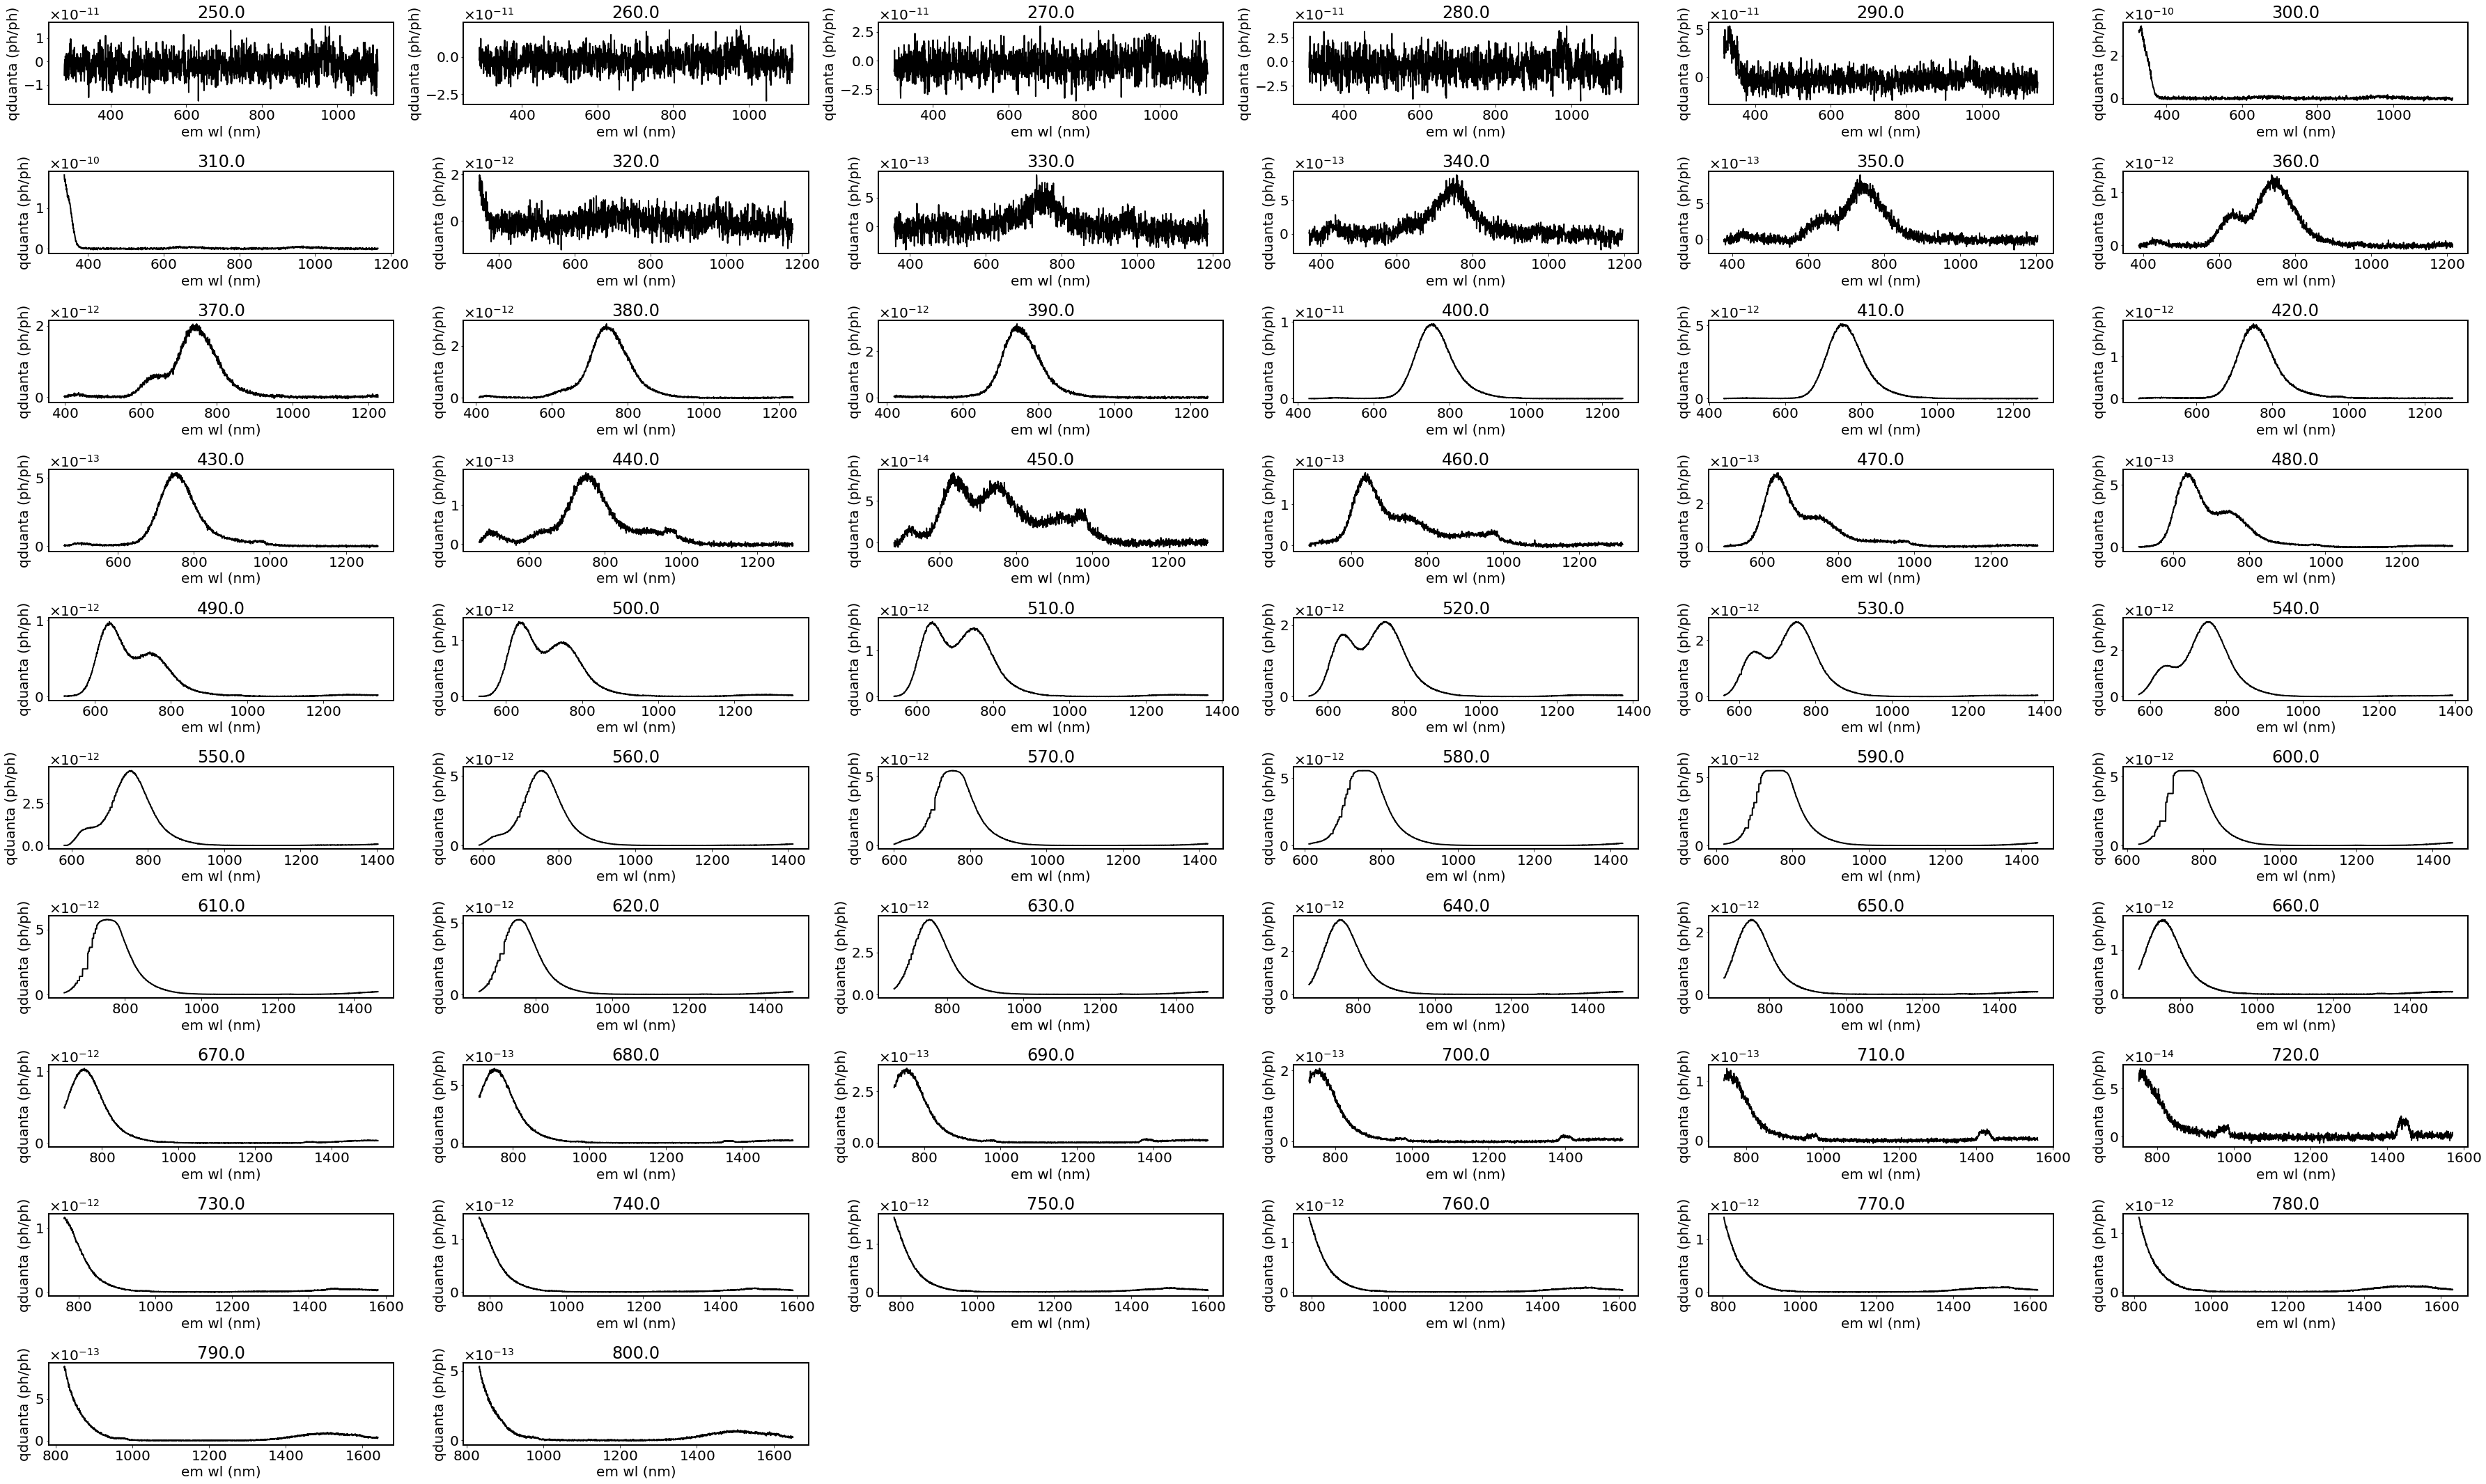

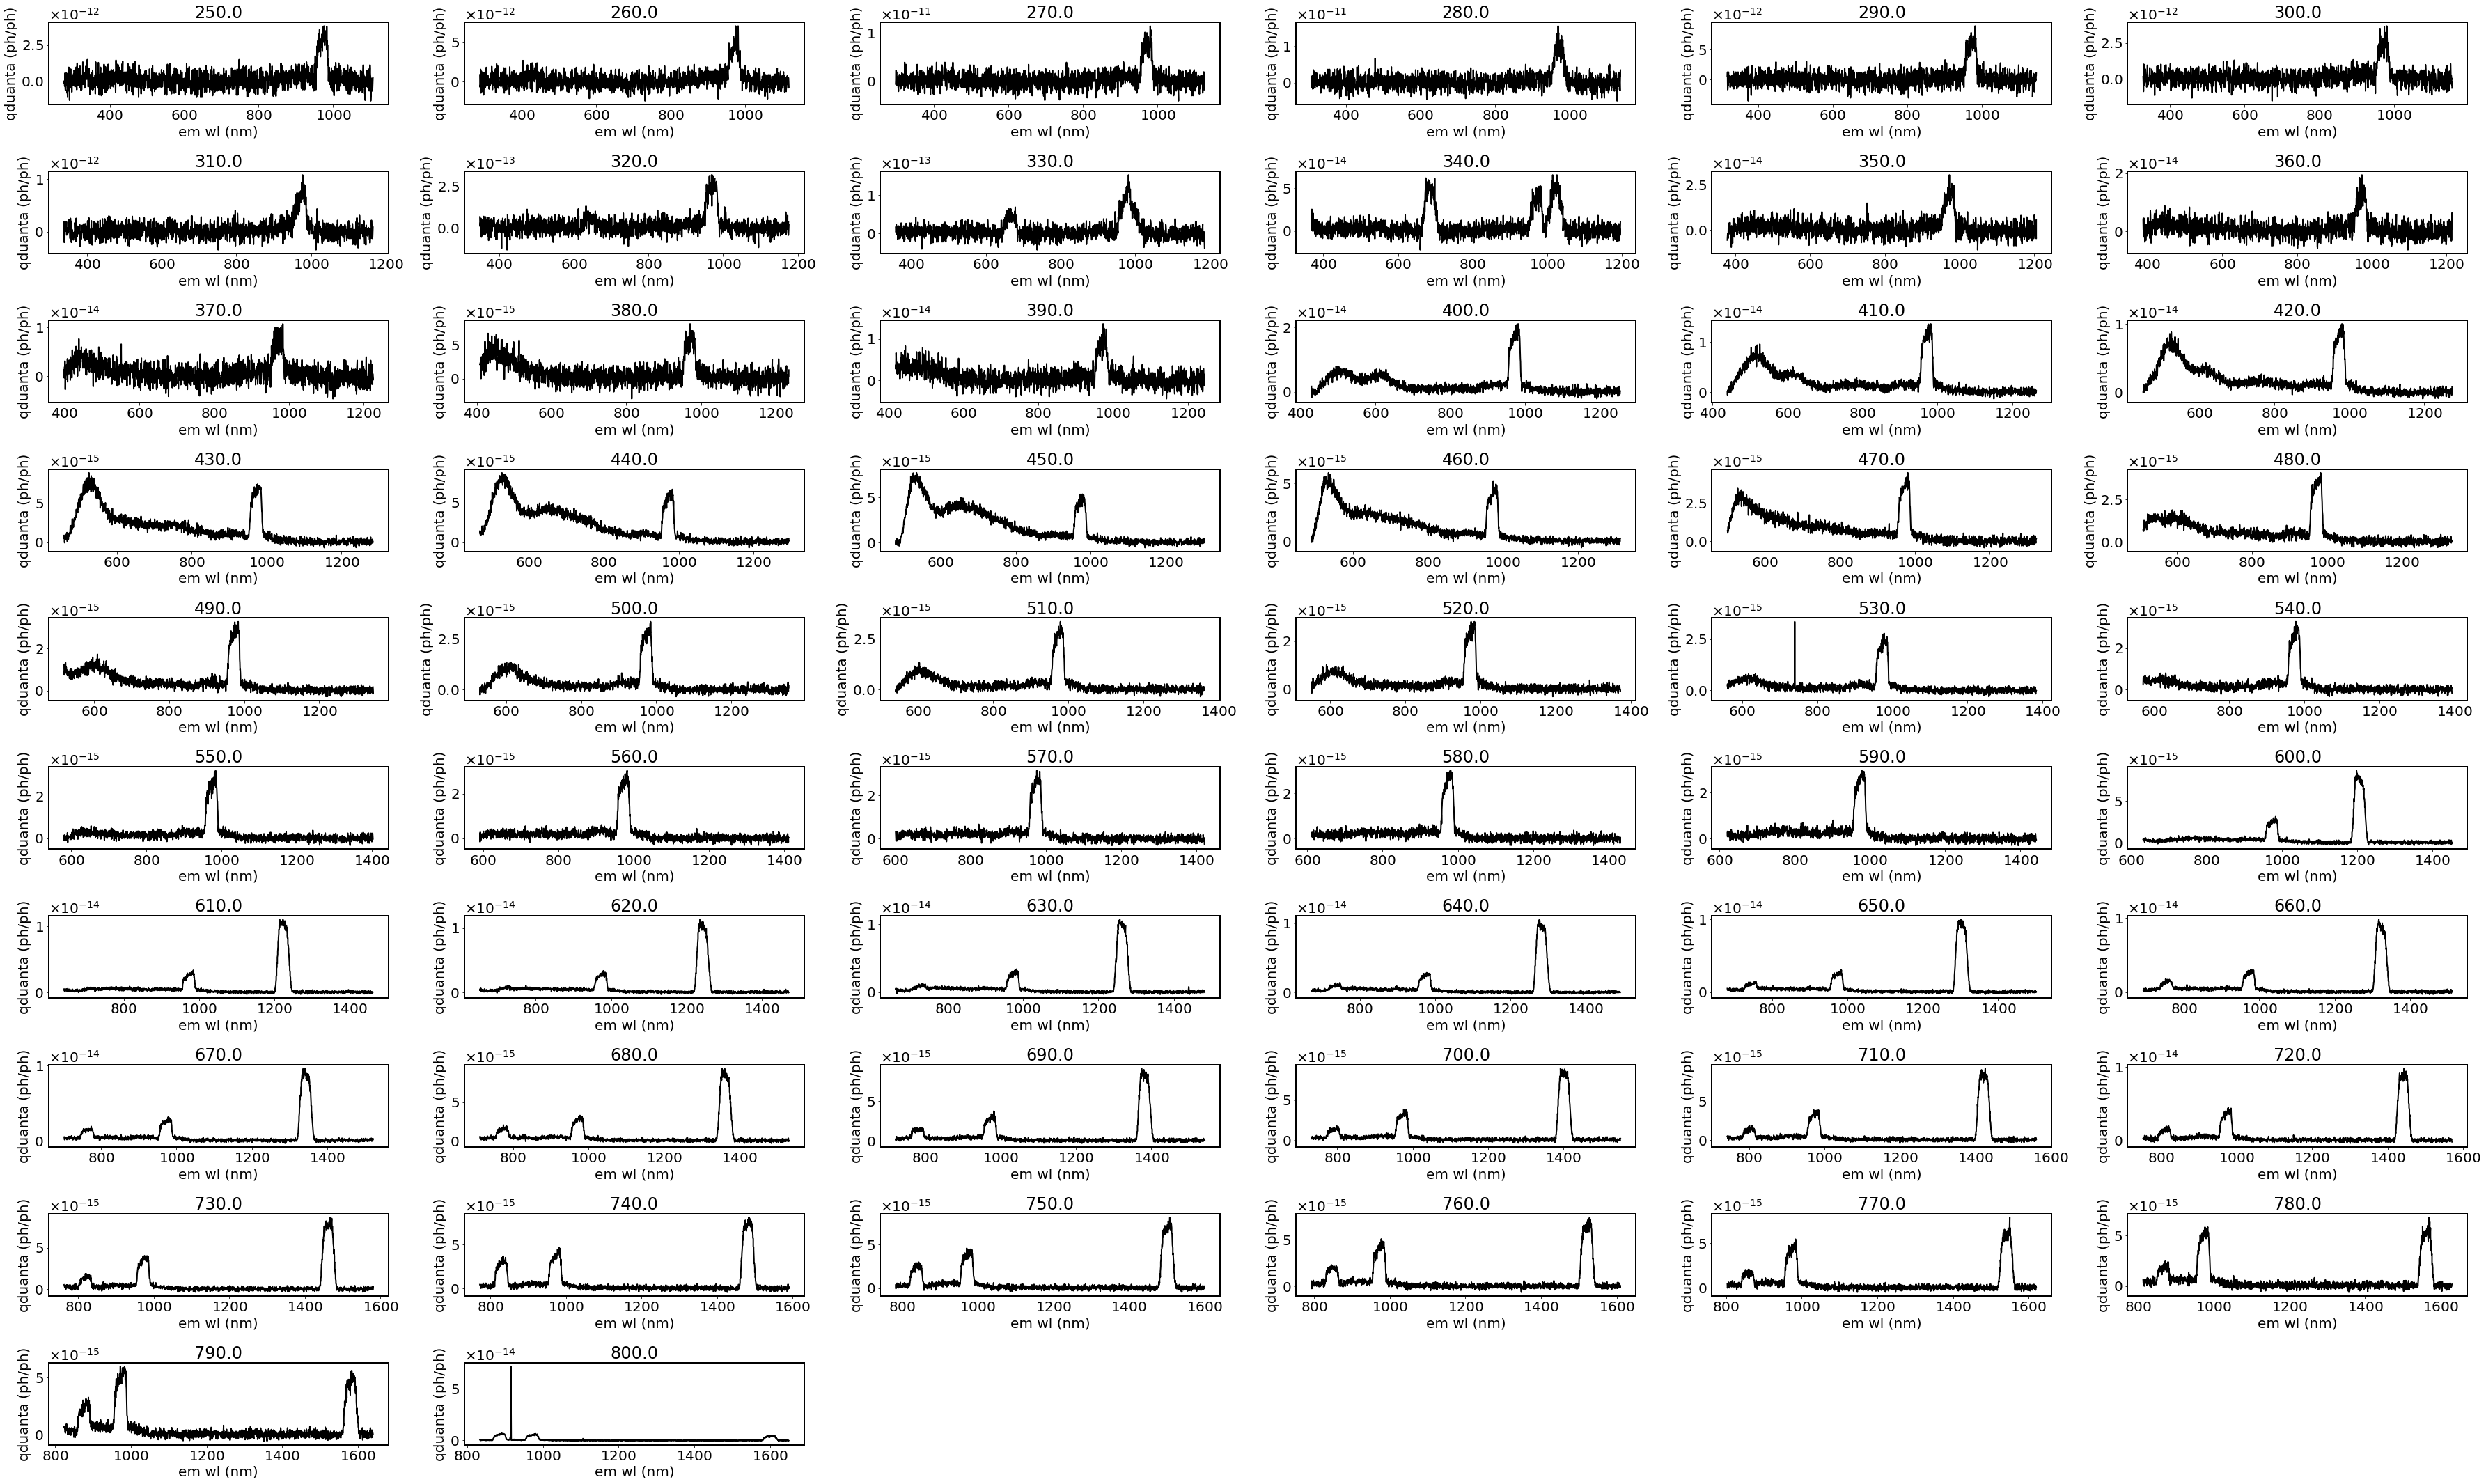

In [10]:
for crystal in (6, 8):
    plt.figure(figsize=(10*5, 6*5))
    e = 2 if crystal == 6 else 10
    groups = filter_df(df, crystal=crystal, grating=2, exposure=e).groupby("ex_wl")

    for k, (ex_wl, data) in enumerate(groups, start=1):
        plt.subplot(10, 6, k)
        plt.plot(data.em_wl, data.dquanta, lw=2)

        plt.xlabel("em wl (nm)")
        plt.ylabel("qduanta (ph/ph)")
        plt.title (str(ex_wl))

    plt.tight_layout()
    plt.savefig(f"/home/gonzalo/Escritorio/caf_{crystal}.pdf")

# 440 nm

Text(0, 0.5, 'qduanta (ph/ph)')

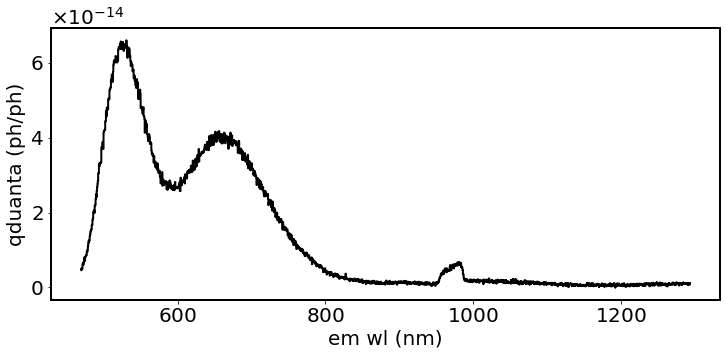

In [10]:
plt.figure(figsize=(12, 5))

data = filter_df(dfs[-1], crystal=4, grating=2, exposure=10, ex_wl=440)
plt.plot(data.em_wl, data.dquanta, drawstyle="steps")
plt.xlabel("em wl (nm)")
plt.ylabel("qduanta (ph/ph)")

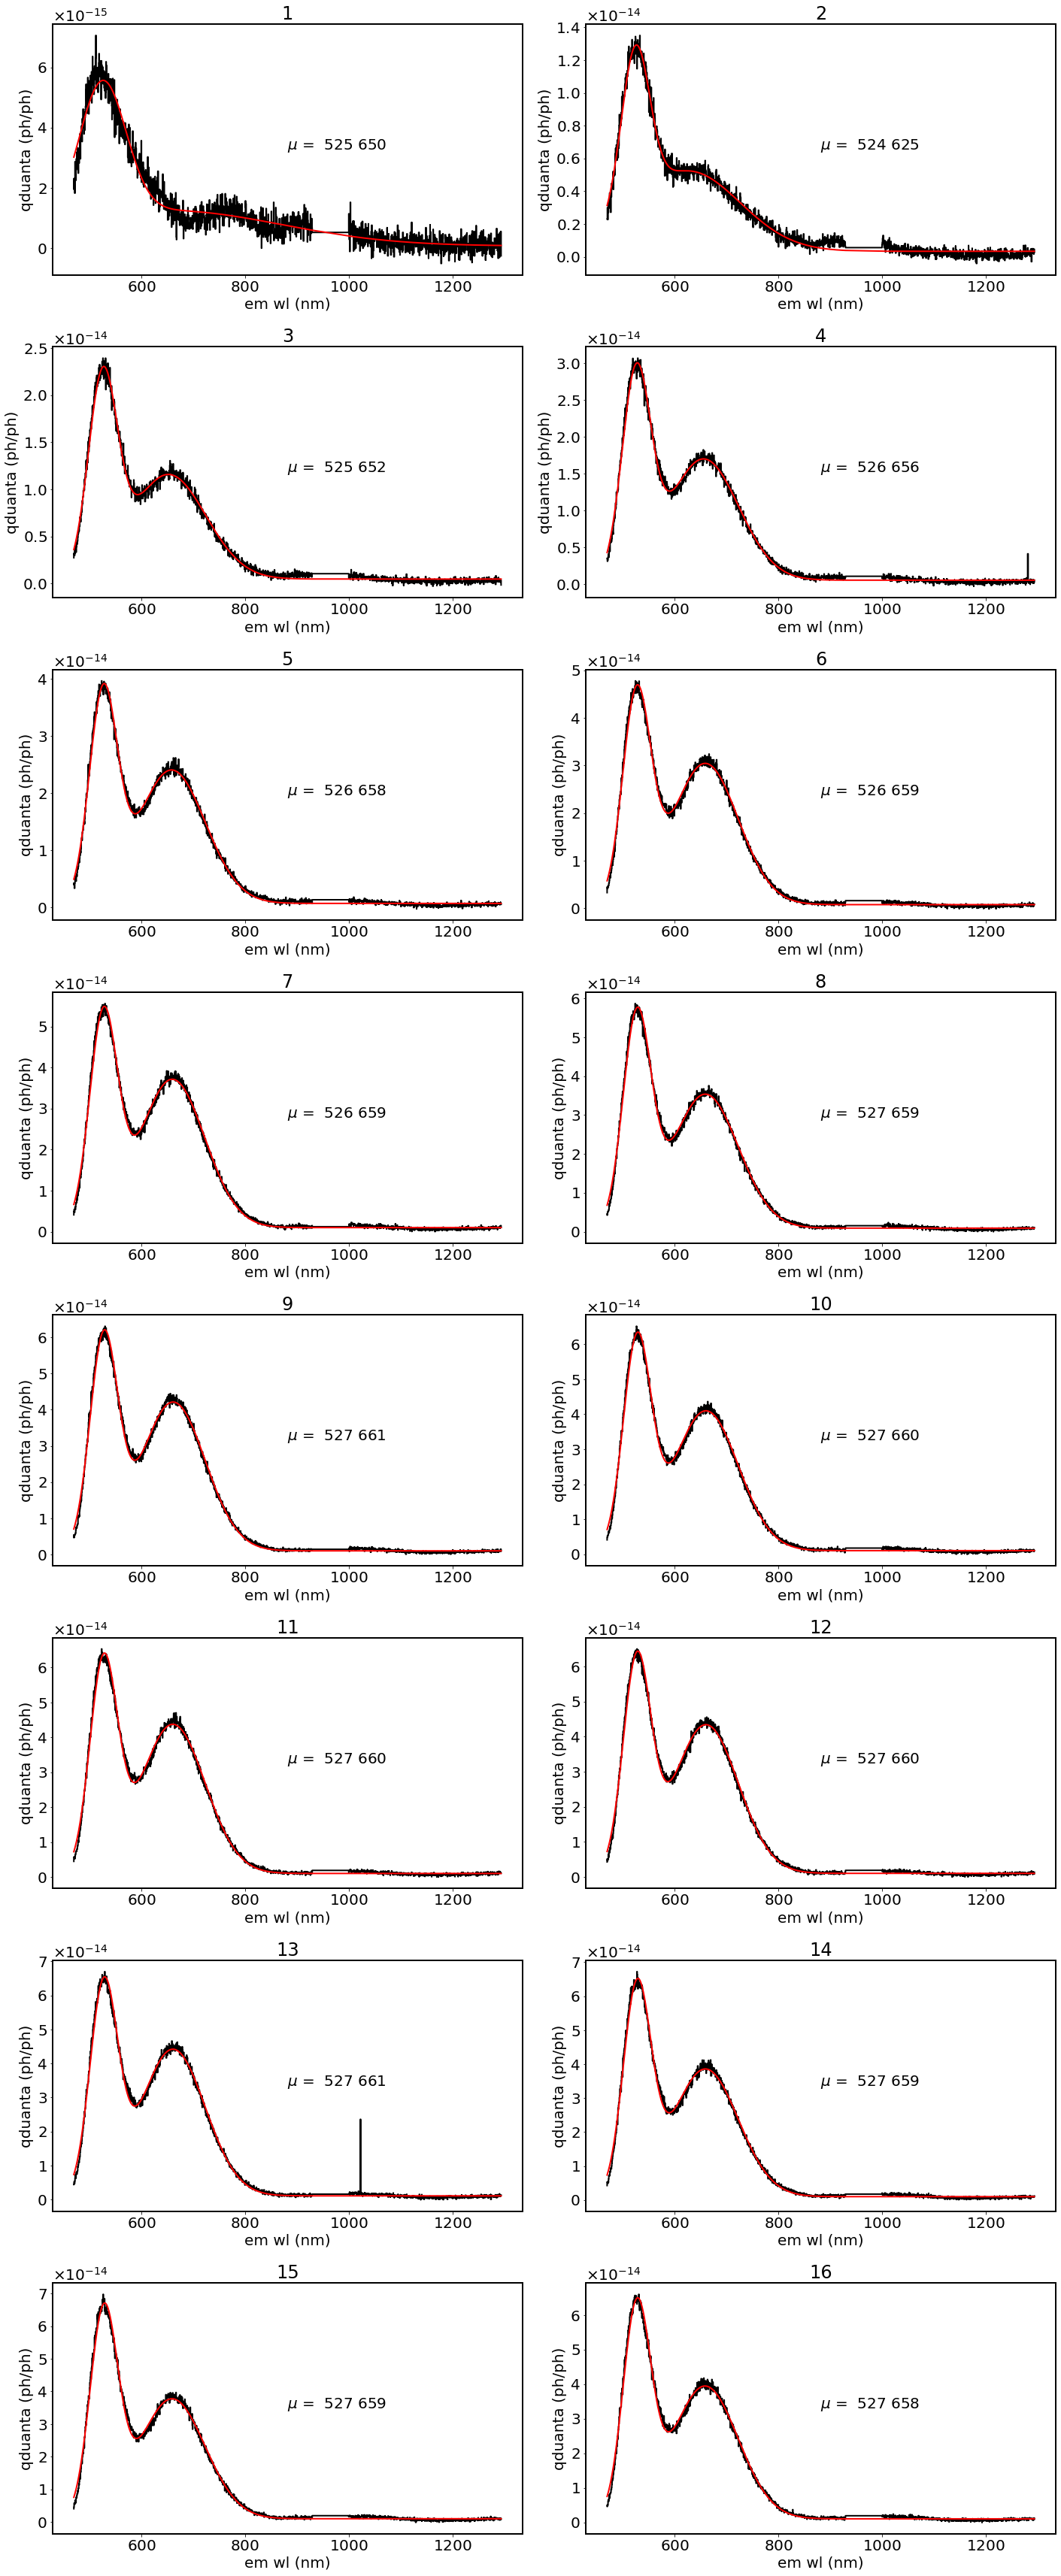

In [11]:
nhalf = int(np.ceil(len(dfs)/2))

plt.figure(figsize=(10*2, 6*nhalf))

fit_values = []

for n, df in enumerate(dfs, start=1):
    data = filter_df(df, crystal=4, grating=2, exposure=10, ex_wl=440)
    data = data[~in_range(data.em_wl, 930, 1000)]
    low  = 1e-16, 500, 20,    1e-16, 600, 40,       0 
    seed = 1e-12, 525, 30,    1e-12, 650, 65,       1e-16
    upp  = 1e-10, 550, 50,    1e-10, 675, 80,       1e-15 

    f    = fit(double_gauss_poly, data.em_wl.values, data.dquanta.values,
               seed      = seed,
               maxfev    = 10**5)
    
    fit_values.append(f.values)
    
    plt.subplot(nhalf, 2, n)
    plt.plot(data.em_wl, data.dquanta, label=str(n), drawstyle="steps")
    plt.plot(data.em_wl, f.fn(data.em_wl), "r-")
    plt.text(0.5, 0.5, " ".join(["$\mu$ = "] + ["{:.0f}".format(x) for x in f.values[1::3]] ), transform=plt.gca().transAxes)
    
    plt.xlabel("em wl (nm)")
    plt.ylabel("qduanta (ph/ph)")
    plt.title (str(n))

plt.tight_layout()

fit_values = np.stack(fit_values)

In [12]:
irrad_time  = np.cumsum(np.append([0], irradiation_times))
a1, m1, s1, a2, m2, s2, c = fit_values.T 

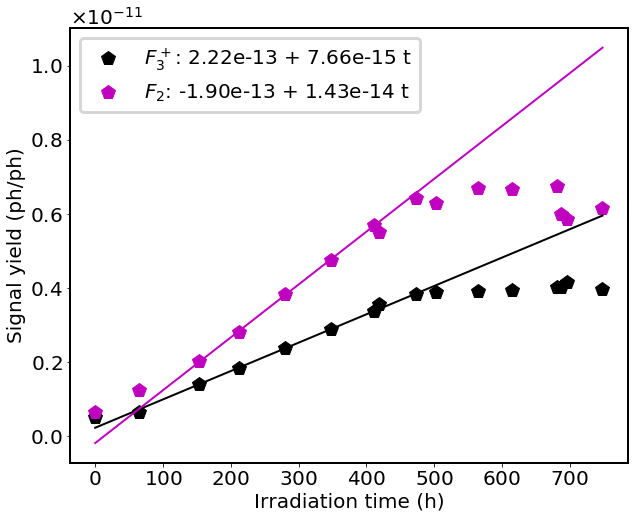

In [13]:
s  = slice(2, 7)
f1 = fit(polynom, irrad_time[s], a1[s], (0, 1))
f2 = fit(polynom, irrad_time[s], a2[s], (0, 1))

plt.plot(irrad_time, a1, "p", label=f"$F_3^+$: {f1.values[0]:.2e} + {f1.values[1]:.2e} t")
plt.plot(irrad_time, a2, "p", label=f"$F_2 $: {f2.values[0]:.2e} + {f2.values[1]:.2e} t")

plt.plot(irrad_time, f1.fn(irrad_time), "-k")
plt.plot(irrad_time, f2.fn(irrad_time), "-m")

plt.xlabel("Irradiation time (h)")
plt.ylabel("Signal yield (ph/ph)")
plt.legend()

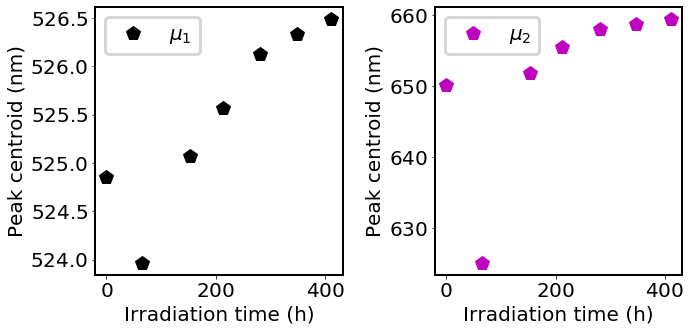

In [14]:
s = slice(7)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(irrad_time[s], m1[s], "pk", label="$\mu_1$")
plt.xlabel("Irradiation time (h)")
plt.ylabel("Peak centroid (nm)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(irrad_time[s], m2[s], "pm", label="$\mu_2$")
plt.xlabel("Irradiation time (h)")
plt.ylabel("Peak centroid (nm)")
plt.legend()

plt.tight_layout()

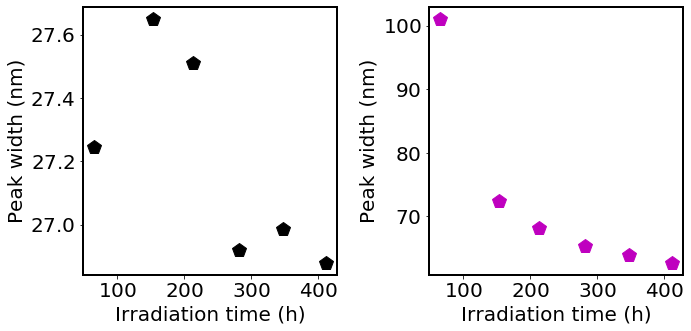

In [15]:
s = slice(1, 7)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(irrad_time[s], s1[s], "pk", label="$\sigma_1$")
plt.xlabel("Irradiation time (h)")
plt.ylabel("Peak width (nm)")

plt.subplot(1, 2, 2)
plt.plot(irrad_time[s], s2[s], "pm", label="$\sigma_2$")
plt.xlabel("Irradiation time (h)")
plt.ylabel("Peak width (nm)")

plt.tight_layout()

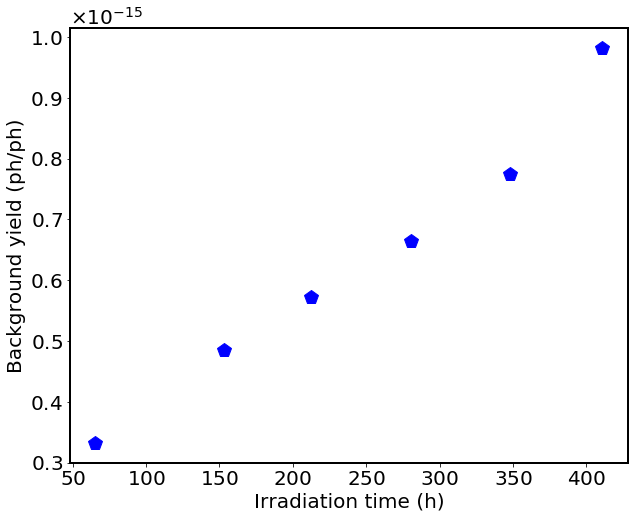

In [16]:
plt.plot(irrad_time[s], c[s], "pb")

plt.xlabel("Irradiation time (h)")
plt.ylabel("Background yield (ph/ph)");